# Long-Short Strategy, Part 6: Backtesting with Zipline

In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. [preparing_the_model_data](04_preparing_the_model_data.ipyny): we engineer a few simple features from the Quandl Wiki data 
2. [trading_signals_with_lightgbm_and_catboost](05_trading_signals_with_lightgbm_and_catboost.ipynb): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. [evaluate_trading_signals](06_evaluate_trading_signals): we compare the cross-validation performance using various metrics to select the best model. 
4. [model_interpretation](07_model_interpretation.ipynb): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb) : we predict returns for our out-of-sample period 2017.
6. `backtesting_with_zipline` (this noteboook): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

## Imports & Settings

> This notebook requires the `conda` environment `backtest`. Please see the [installation instructions](../installation/README.md) for running the latest Docker image or alternative ways to set up your environment.

In [2]:
from collections import defaultdict
from time import time
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import pandas_datareader.data as web
from logbook import Logger, StderrHandler, INFO, WARNING

from zipline import run_algorithm
from zipline.api import (attach_pipeline, pipeline_output,
                         date_rules, time_rules, record,
                         schedule_function, commission, slippage,
                         set_slippage, set_commission, set_max_leverage,
                         order_target, order_target_percent,
                         get_open_orders, cancel_order)
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet
from zipline.pipeline.domain import US_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.pipeline.loaders.frame import DataFrameLoader
from trading_calendars import get_calendar

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

In [3]:
# optional; not pre-installed; see above
# import seaborn as sns
# sns.set_style('darkgrid')

In [4]:
warnings.filterwarnings('ignore')
np.random.seed(42)

### Load zipline extensions

Only need this in notebook to find bundle.

In [5]:
load_extensions(default=True,
                extensions=[],
                strict=True,
                environ=None)

In [6]:
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=WARNING)
log_handler.push_application()
log = Logger('Algorithm')

## Algo Params

In [7]:
N_LONGS = 25
N_SHORTS = 25
MIN_POSITIONS = 20

## Load Data

### Quandl Wiki Bundle

Requires running `zipline ingest` (see installation instructions and Chapter 8). If you haven't done so yet (but have provided your QUANDL API KEY when launching Docker), uncomment and run the following cell:

In [8]:
# !zipline ingest

In [9]:
bundle_data = bundles.load('quandl')

### ML Predictions

If you run into difficulties reading the predictions, run the following to upgrade `tables` ([source](https://stackoverflow.com/questions/54210073/pd-read-hdf-throws-cannot-set-writable-flag-to-true-of-this-array)).

In [10]:
# !pip install --upgrade tables

In [11]:
def load_predictions(bundle):
    predictions = (pd.read_hdf('data/predictions.h5', 'lgb/train/01')
                   .append(pd.read_hdf('data/predictions.h5', 'lgb/test/01').drop('y_test', axis=1)))
    predictions = (predictions.loc[~predictions.index.duplicated()]
                   .iloc[:, :10]
                   .mean(1)
                   .sort_index()
                   .dropna()
                  .to_frame('prediction'))
    tickers = predictions.index.get_level_values('symbol').unique().tolist()

    assets = bundle.asset_finder.lookup_symbols(tickers, as_of_date=None)
    predicted_sids = pd.Int64Index([asset.sid for asset in assets])
    ticker_map = dict(zip(tickers, predicted_sids))

    return (predictions
            .unstack('symbol')
            .rename(columns=ticker_map)
            .prediction
            .tz_localize('UTC')), assets

In [12]:
predictions, assets = load_predictions(bundle_data)

In [13]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 753 entries, 2015-01-02 to 2017-12-28
Columns: 995 entries, 0 to 3188
dtypes: float64(995)
memory usage: 5.7 MB


### Define Custom Dataset

In [14]:
class SignalData(DataSet):
    predictions = Column(dtype=float)
    domain = US_EQUITIES

### Define Pipeline Loaders

In [15]:
signal_loader = {SignalData.predictions:
                     DataFrameLoader(SignalData.predictions, predictions)}

## Pipeline Setup

### Custom ML Factor

In [16]:
class MLSignal(CustomFactor):
    """Converting signals to Factor
        so we can rank and filter in Pipeline"""
    inputs = [SignalData.predictions]
    window_length = 1

    def compute(self, today, assets, out, predictions):
        out[:] = predictions

### Create Pipeline

In [17]:
def compute_signals():
    signals = MLSignal()
    return Pipeline(columns={
        'longs' : signals.top(N_LONGS, mask=signals > 0),
        'shorts': signals.bottom(N_SHORTS, mask=signals < 0)},
            screen=StaticAssets(assets))

## Initialize Algorithm

In [18]:
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.n_longs = N_LONGS
    context.n_shorts = N_SHORTS
    context.min_positions = MIN_POSITIONS
    context.universe = assets
    context.trades = pd.Series()
    context.longs = context.shorts = 0
    
    set_slippage(slippage.FixedSlippage(spread=0.00))
    set_commission(commission.PerShare(cost=0.001, min_trade_cost=0))

    schedule_function(rebalance,
                      date_rules.every_day(),
#                       date_rules.week_start(),
                      time_rules.market_open(hours=1, minutes=30))

    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())

    pipeline = compute_signals()
    attach_pipeline(pipeline, 'signals')

### Get daily Pipeline results

In [19]:
def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    output = pipeline_output('signals')
    df = (output['longs'].astype(int)
                      .append(output['shorts'].astype(int).mul(-1)))
    
    holdings = df[df!=0]
    other = df[df==0]
    other = other[~other.index.isin(holdings.index) & ~other.index.duplicated()]
    context.trades = holdings.append(other)
    assert len(context.trades.index.unique()) == len(context.trades)

## Define Rebalancing Logic

In [20]:
def rebalance(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    trades = defaultdict(list)
    for symbol, open_orders in get_open_orders().items():
        for open_order in open_orders:
            cancel_order(open_order)
      
    positions = context.portfolio.positions
    s=pd.Series({s:v.amount*v.last_sale_price for s, v in positions.items()}).sort_values(ascending=False)
    for stock, trade in context.trades.items():
        if trade == 0:
            order_target(stock, target=0)
        else:
            trades[trade].append(stock)
    
    context.longs, context.shorts = len(trades[1]), len(trades[-1])
#     log.warning('{} {:,.0f}'.format(len(positions), context.portfolio.portfolio_value))
    if context.longs > context.min_positions and context.shorts > context.min_positions:
        for stock in trades[-1]:
            order_target_percent(stock, -1 / context.shorts)
        for stock in trades[1]:
            order_target_percent(stock, 1 / context.longs)
    else:
        for stock in trades[-1] + trades[1]:
            if stock in positions:
                order_target(stock, 0)

## Record Data Points

In [21]:
def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    record(leverage=context.account.leverage,
           longs=context.longs,
           shorts=context.shorts)

## Run Algorithm

We backtest our strategy during the (in-sample) validation and out-of-sample test period:

In [22]:
dates = predictions.index.get_level_values('date')
start_date, end_date = dates.min(), dates.max()

In [23]:
print('Start: {}\nEnd:   {}'.format(start_date.date(), end_date.date()))

Start: 2015-01-02
End:   2017-12-28


In [24]:
start = time()
results = run_algorithm(start=start_date,
                        end=end_date,
                        initialize=initialize,
                        before_trading_start=before_trading_start,
                        capital_base=1e5,
                        data_frequency='daily',
                        bundle='quandl',
                        custom_loader=signal_loader)  # need to modify zipline

print('Duration: {:.2f}s'.format(time() - start))

[2021-01-24 00:45:44.194335]: WARNING: ensure_benchmark_data: Still don't have expected benchmark data for 'SPY' from 1989-12-29 00:00:00+00:00 to 2021-01-22 00:00:00+00:00 after redownload!
[2021-01-24 00:45:45.558137]: WARNING: ensure_treasury_data: Still don't have expected treasury data for 'SPY' from 1990-01-02 00:00:00+00:00 to 2021-01-22 00:00:00+00:00 after redownload!


Duration: 70.60s


## PyFolio Analysis

To visualize the out-of-sample performance, we pass '2017-01-01' as start date for the `live_start_date`:

In [26]:
returns, positions, transactions, _ = pf.utils.extract_rets_pos_txn_from_zipline(results)

In [27]:
benchmark = web.DataReader('SP500', 'fred', '2014', '2018').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

### Custom Plots

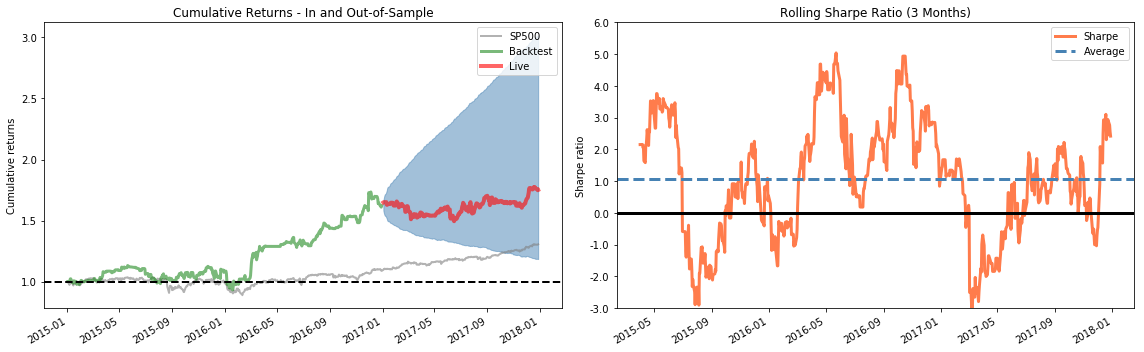

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns,
                     factor_returns=benchmark,
                     live_start_date='2017-01-01',
                     logy=False,
                     cone_std=2,
                     legend_loc='best',
                     volatility_match=False,
                     cone_function=forecast_cone_bootstrap,
                    ax=axes[0])
plot_rolling_sharpe(returns, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
fig.tight_layout();

### Tear Sheets

Entire data start date: 2015-01-02
Entire data end date: 2017-12-28


Out-of-Sample Months: 11
Backtest Months: 24


Performance statistics,All history,Backtest,Out of sample
annual_return,0.21,0.27,0.08
annual_volatility,0.19,0.21,0.14
sharpe_ratio,1.06,1.24,0.61
calmar_ratio,1.17,1.55,0.82
stability_of_timeseries,0.93,0.87,0.56
max_drawdown,-0.18,-0.18,-0.10
omega_ratio,1.26,1.31,1.13
sortino_ratio,1.69,2.01,0.87
skew,0.86,0.95,-0.16
kurtosis,8.61,7.94,3.07


Worst Drawdown Periods,net drawdown in %,peak date,valley date,recovery date,duration
0,17.59,2015-05-21,2016-01-20,2016-03-03,206
1,13.81,2016-12-05,2017-06-16,2017-12-07,264
2,6.04,2016-06-08,2016-06-16,2016-08-01,39
3,4.94,2016-03-14,2016-03-15,2016-03-21,6
4,4.56,2015-01-09,2015-01-29,2015-03-05,40




[-0.024 -0.048]


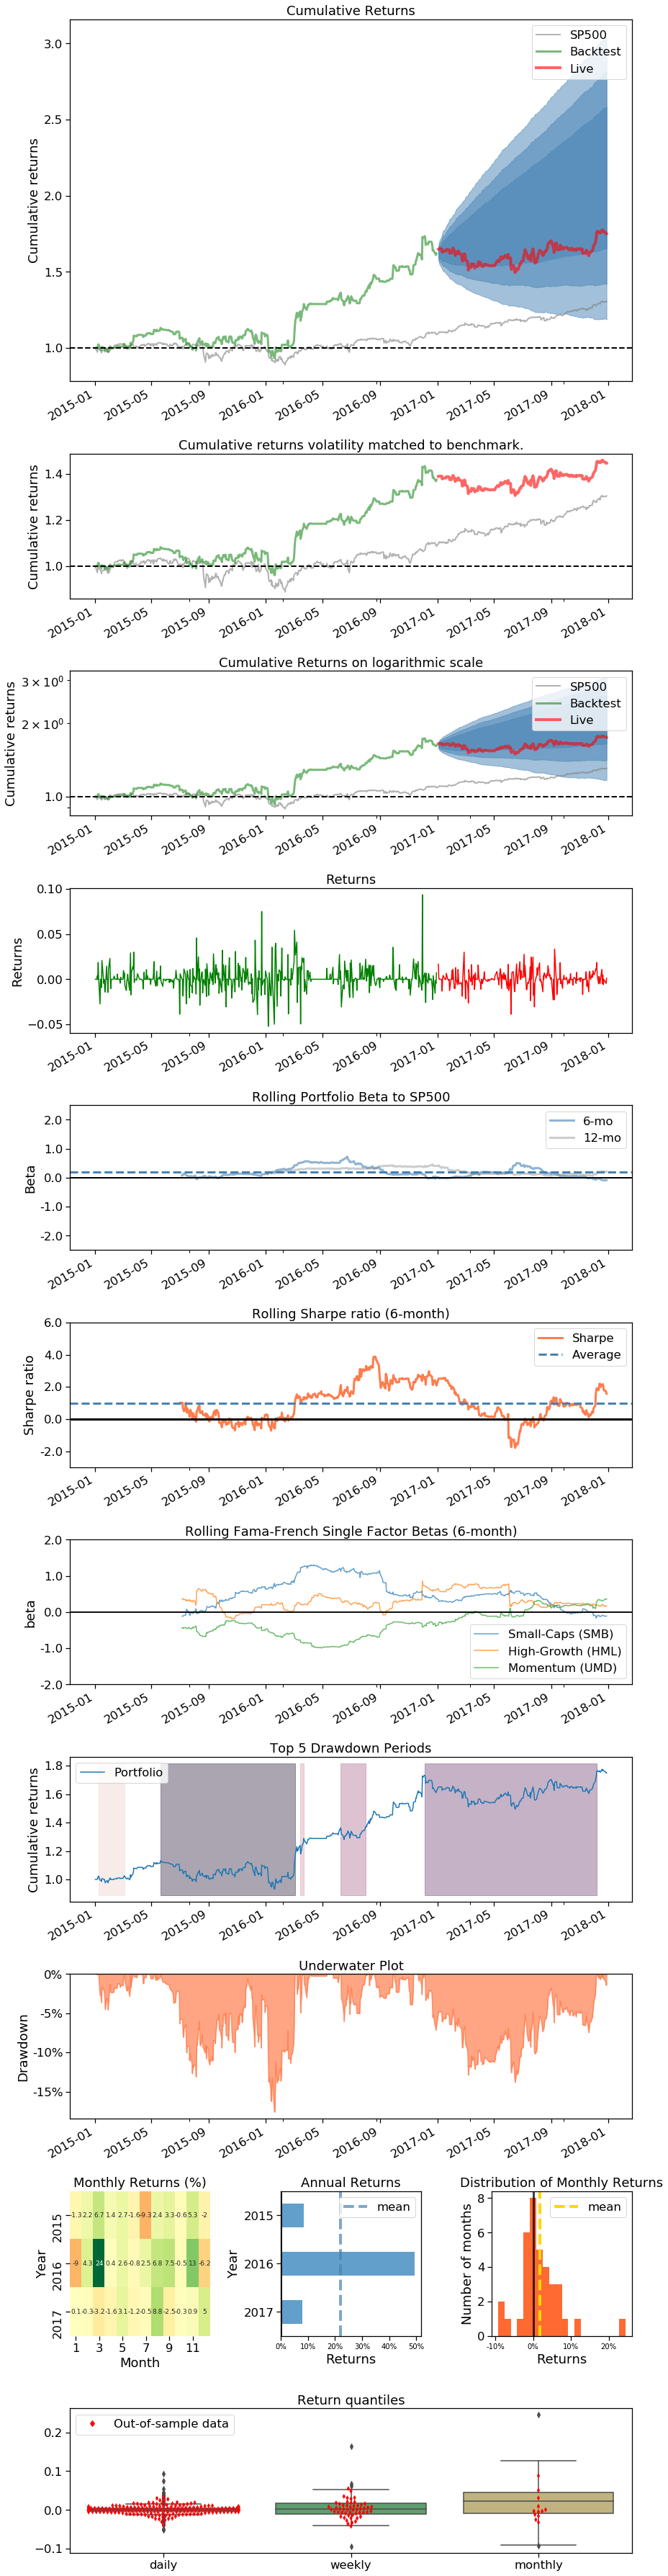

Stress Events,mean,min,max
Fall2015,0.10%,-1.92%,3.20%
New Normal,0.08%,-5.21%,9.35%


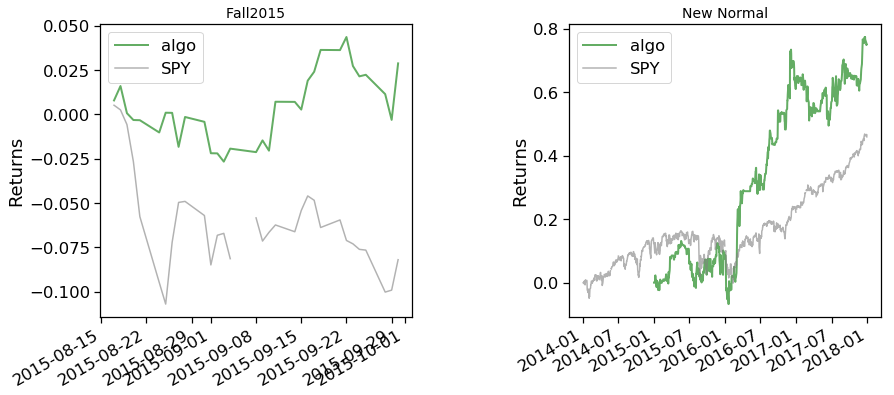

Top 10 long positions of all time,max
Equity(130 [ALNY]),5.98%
Equity(1994 [NKTR]),5.67%
Equity(1791 [MDR]),5.33%
Equity(1056 [FCX]),5.24%
Equity(245 [ATI]),5.24%
Equity(2852 [TROX]),5.21%
Equity(2046 [NVDA]),5.07%
Equity(2598 [SM]),5.07%
Equity(590 [CLF]),5.02%
Equity(1154 [FTI]),4.98%


Top 10 short positions of all time,max
Equity(3029 [VRX]),-5.08%
Equity(1092 [FIZZ]),-5.08%
Equity(1482 [INCY]),-5.06%
Equity(1394 [HRTX]),-4.91%
Equity(623 [CNK]),-4.84%
Equity(1666 [LEN]),-4.82%
Equity(959 [ENV]),-4.81%
Equity(2659 [SSNC]),-4.79%
Equity(3113 [WRB]),-4.76%
Equity(261 [ATVI]),-4.75%


Top 10 positions of all time,max
Equity(130 [ALNY]),5.98%
Equity(1994 [NKTR]),5.67%
Equity(1791 [MDR]),5.33%
Equity(1056 [FCX]),5.24%
Equity(245 [ATI]),5.24%
Equity(2852 [TROX]),5.21%
Equity(3029 [VRX]),5.08%
Equity(1092 [FIZZ]),5.08%
Equity(2046 [NVDA]),5.07%
Equity(2598 [SM]),5.07%


All positions ever held,max
Equity(130 [ALNY]),5.98%
Equity(1994 [NKTR]),5.67%
Equity(1791 [MDR]),5.33%
Equity(1056 [FCX]),5.24%
Equity(245 [ATI]),5.24%
Equity(2852 [TROX]),5.21%
Equity(3029 [VRX]),5.08%
Equity(1092 [FIZZ]),5.08%
Equity(2046 [NVDA]),5.07%
Equity(2598 [SM]),5.07%


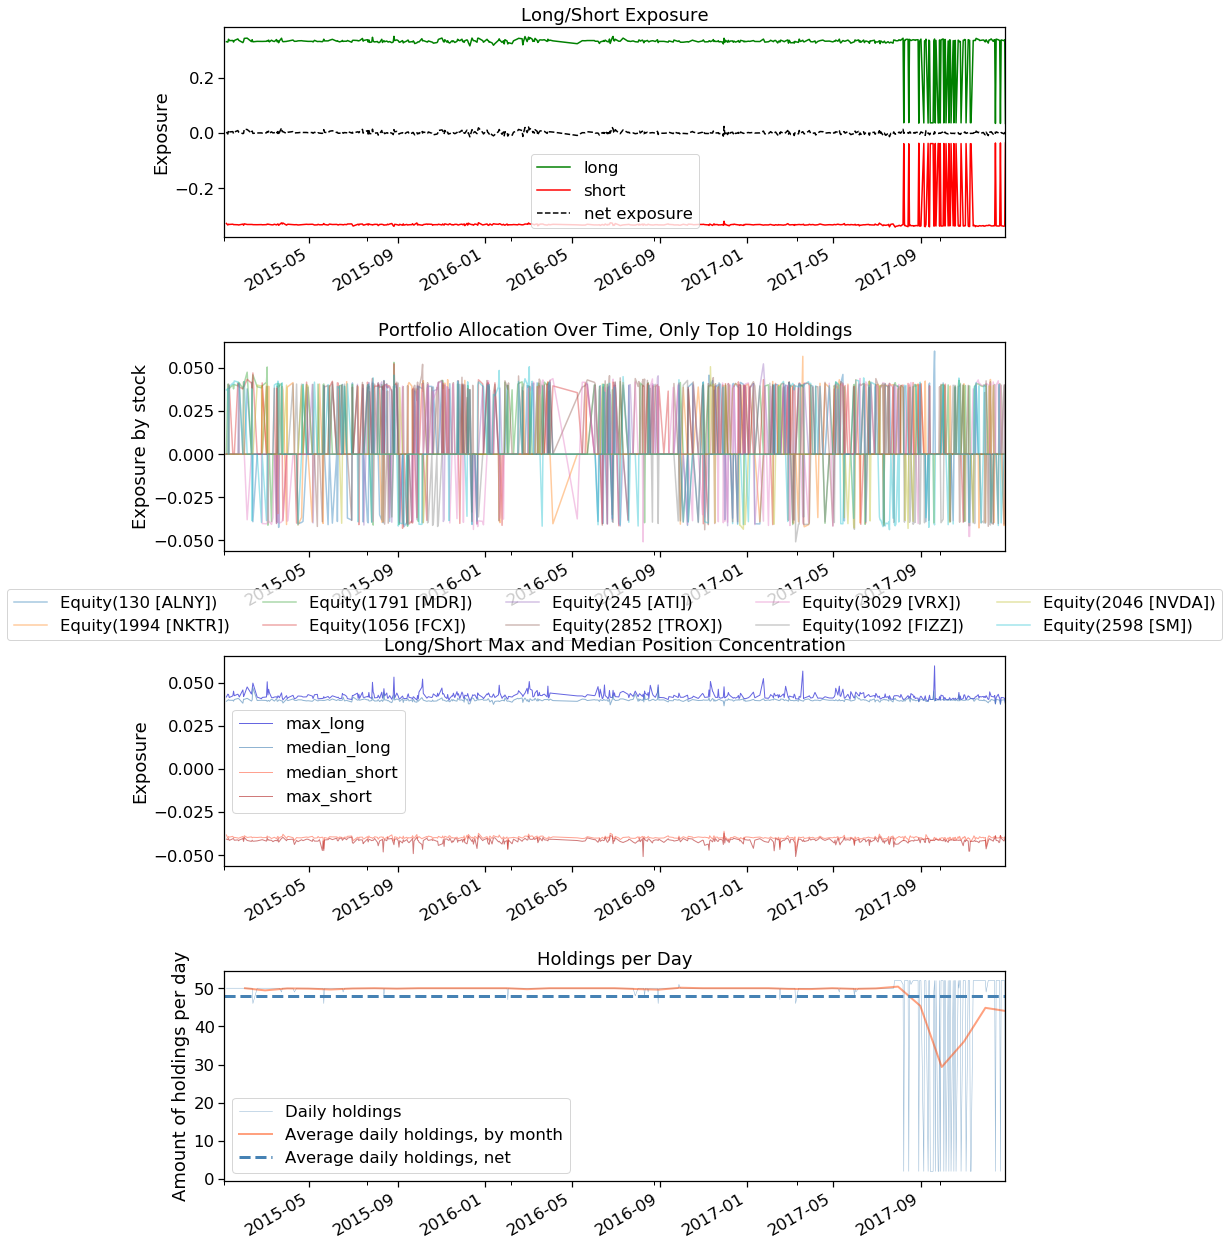

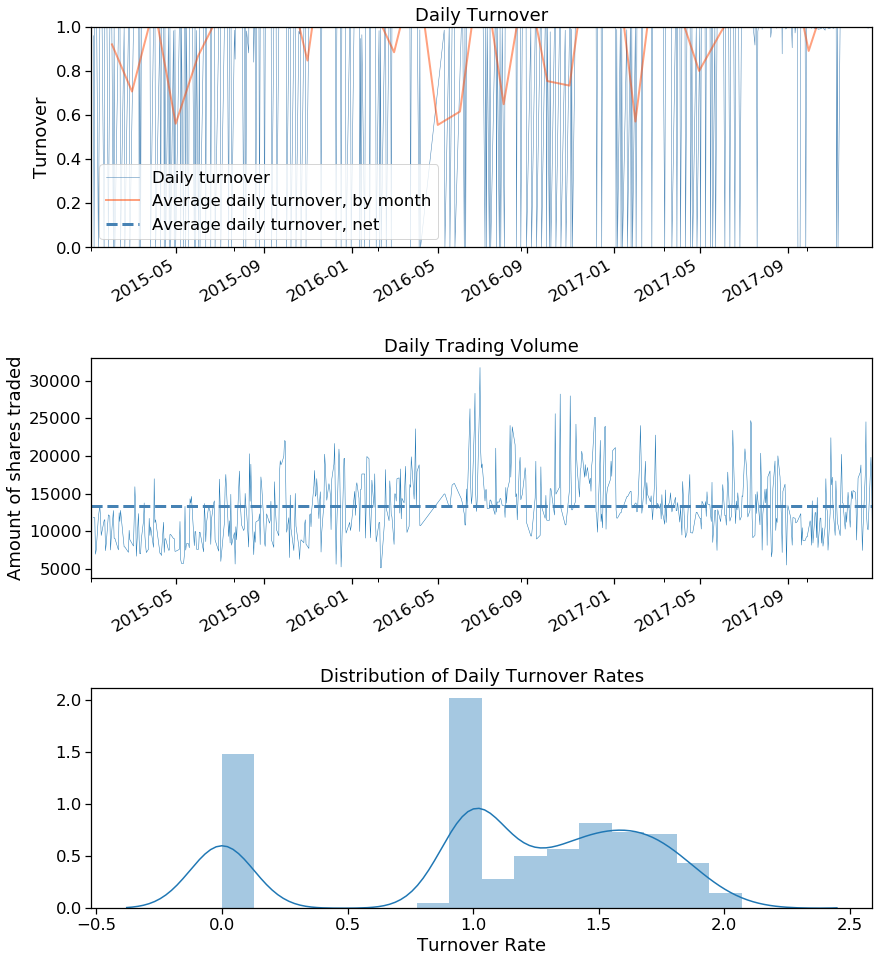

Summary stats,All trades,Short trades,Long trades
Total number of round_trips,22352.00,11631.00,10721.00
Percent profitable,0.50,0.48,0.51
Winning round_trips,11131.00,5616.00,5515.00
Losing round_trips,11023.00,5935.00,5088.00
Even round_trips,198.00,80.00,118.00


PnL stats,All trades,Short trades,Long trades
Total profit,$85809.27,$-7871.93,$93681.19
Gross profit,$1085009.15,$452525.02,$632484.13
Gross loss,$-999199.89,$-460396.95,$-538802.94
Profit factor,$1.09,$0.98,$1.17
Avg. trade net profit,$3.84,$-0.68,$8.74
Avg. winning trade,$97.48,$80.58,$114.68
Avg. losing trade,$-90.65,$-77.57,$-105.90
Ratio Avg. Win:Avg. Loss,$1.08,$1.04,$1.08
Largest winning trade,$3333.44,$3163.32,$3333.44
Largest losing trade,$-3381.31,$-1812.02,$-3381.31


Duration stats,All trades,Short trades,Long trades
Avg duration,1 days 19:59:30.365157,1 days 16:55:20.505631,1 days 23:19:18.138326
Median duration,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00
Avg # round_trips per day,118.26,73.15,56.72
Avg # round_trips per month,2483.56,1536.17,1191.22


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.00%,-0.00%,0.01%
Avg returns winning,0.07%,0.06%,0.08%
Avg returns losing,-0.07%,-0.06%,-0.08%
Median returns all round_trips,0.00%,-0.00%,0.00%
Median returns winning,0.04%,0.04%,0.04%
Median returns losing,-0.04%,-0.04%,-0.04%
Largest winning trade,2.61%,1.97%,2.61%
Largest losing trade,-2.01%,-1.18%,-2.01%


Symbol stats,Equity(0 [A]),Equity(2 [AAL]),Equity(4 [AAN]),Equity(7 [AAP]),Equity(8 [AAPL]),Equity(13 [ABC]),Equity(19 [ABMD]),Equity(20 [ABT]),Equity(24 [ACC]),Equity(30 [ACGL]),...,Equity(3151 [XLNX]),Equity(3156 [XOM]),Equity(3162 [XPO]),Equity(3163 [XRAY]),Equity(3165 [XRX]),Equity(3169 [Y]),Equity(3175 [YUM]),Equity(3180 [ZBH]),Equity(3181 [ZBRA]),Equity(3188 [ZION])
Avg returns all round_trips,-0.03%,-0.02%,-0.03%,0.00%,0.03%,-0.01%,0.01%,0.01%,0.00%,0.01%,...,0.00%,0.00%,-0.02%,-0.00%,-0.03%,0.01%,-0.03%,0.04%,-0.00%,0.06%
Avg returns winning,0.00%,0.05%,0.06%,0.07%,0.05%,0.03%,0.07%,0.03%,0.05%,0.02%,...,0.03%,0.03%,0.09%,0.03%,0.02%,0.08%,0.01%,0.06%,0.07%,0.09%
Avg returns losing,-0.03%,-0.07%,-0.08%,-0.06%,-0.03%,-0.04%,-0.07%,-0.02%,-0.04%,-0.02%,...,-0.03%,-0.04%,-0.14%,-0.03%,-0.06%,-0.03%,-0.06%,-0.01%,-0.09%,-0.10%
Median returns all round_trips,-0.03%,-0.00%,-0.01%,-0.02%,0.02%,-0.00%,0.00%,0.01%,-0.00%,0.01%,...,-0.00%,0.00%,0.00%,-0.01%,-0.03%,-0.02%,-0.02%,0.01%,0.00%,0.07%
Median returns winning,0.00%,0.03%,0.04%,0.05%,0.04%,0.03%,0.06%,0.03%,0.06%,0.02%,...,0.02%,0.02%,0.07%,0.03%,0.02%,0.08%,0.01%,0.06%,0.04%,0.10%
Median returns losing,-0.03%,-0.05%,-0.05%,-0.05%,-0.03%,-0.04%,-0.03%,-0.02%,-0.04%,-0.02%,...,-0.01%,-0.02%,-0.12%,-0.02%,-0.04%,-0.03%,-0.04%,-0.01%,-0.06%,-0.10%
Largest winning trade,0.00%,0.21%,0.15%,0.16%,0.14%,0.05%,0.28%,0.03%,0.08%,0.04%,...,0.07%,0.10%,0.32%,0.05%,0.04%,0.13%,0.03%,0.11%,0.33%,0.17%
Largest losing trade,-0.07%,-0.23%,-0.29%,-0.11%,-0.03%,-0.15%,-0.22%,-0.02%,-0.07%,-0.03%,...,-0.07%,-0.14%,-0.43%,-0.06%,-0.11%,-0.03%,-0.16%,-0.01%,-0.33%,-0.10%


Profitability (PnL / PnL total) per name,pnl
symbol,
Equity(1478 [IMMU]),0.10%
Equity(2071 [OAS]),0.07%
Equity(1218 [GLNG]),0.07%
Equity(3095 [WLL]),0.06%
Equity(1394 [HRTX]),0.05%
Equity(771 [CXW]),0.04%
Equity(1917 [MUR]),0.04%
Equity(1791 [MDR]),0.04%
Equity(2852 [TROX]),0.04%


<Figure size 1008x1296 with 0 Axes>

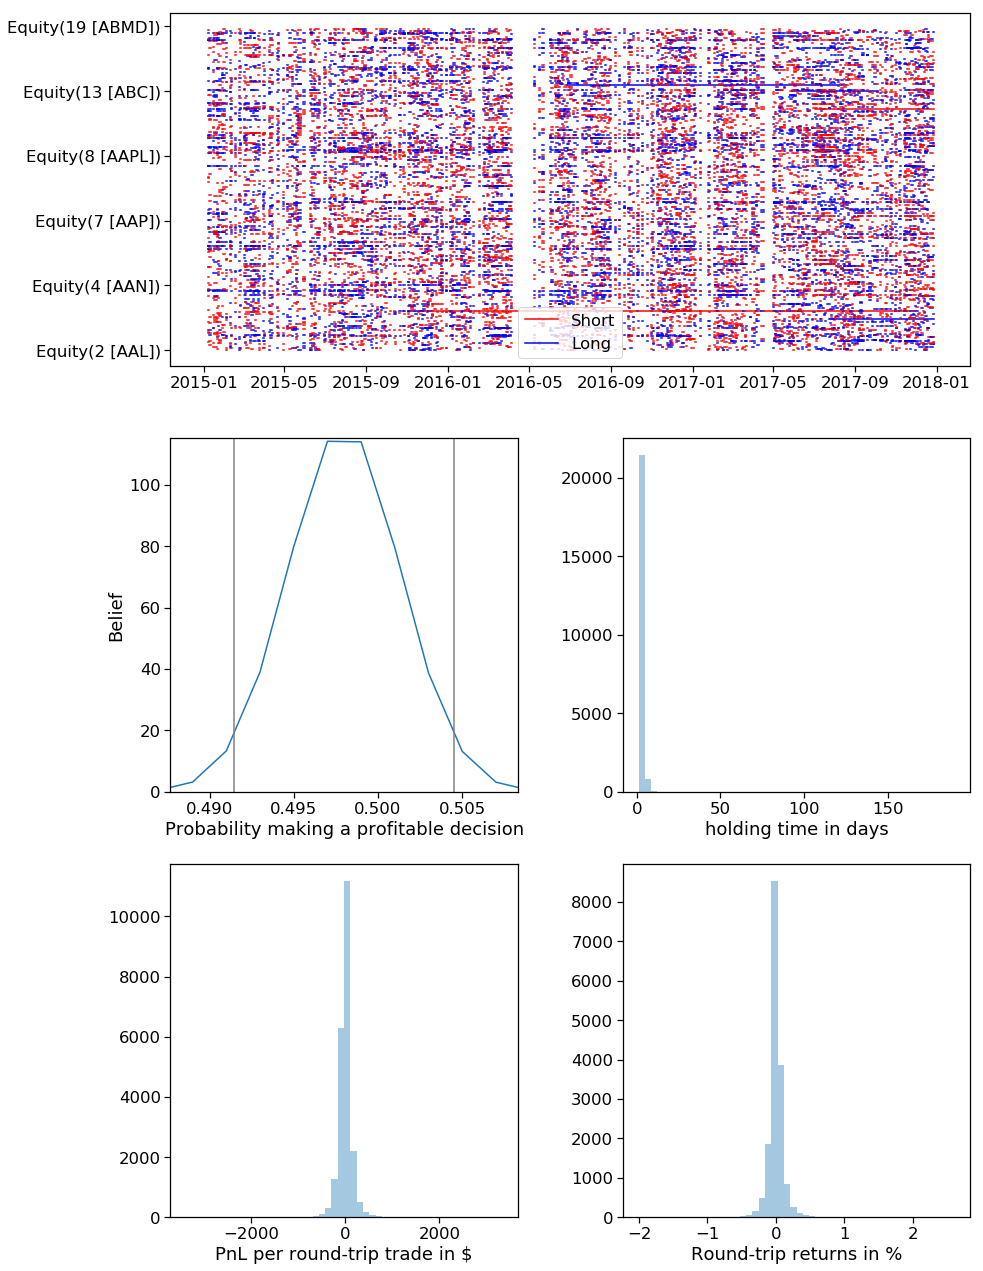

In [29]:
pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          live_start_date='2017-01-01', 
                          round_trips=True)